In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

2025-11-28 19:57:27.547077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764356247.559018   45613 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764356247.562711   45613 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764356247.573132   45613 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764356247.573142   45613 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764356247.573143   45613 computation_placer.cc:177] computation placer alr

In [2]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [3]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|█████████████████████████████████████████| 300/300 [23:34<00:00,  4.72s/it]


val :


100%|█████████████████████████████████████████| 100/100 [07:50<00:00,  4.71s/it]


test :


100%|█████████████████████████████████████████| 100/100 [08:27<00:00,  5.07s/it]


In [4]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

I0000 00:00:1764358697.184131   45613 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9154 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [5]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [6]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [7]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [8]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [9]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [10]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [11]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [12]:
frames, label = next(iter(train_ds))
model.build(frames)

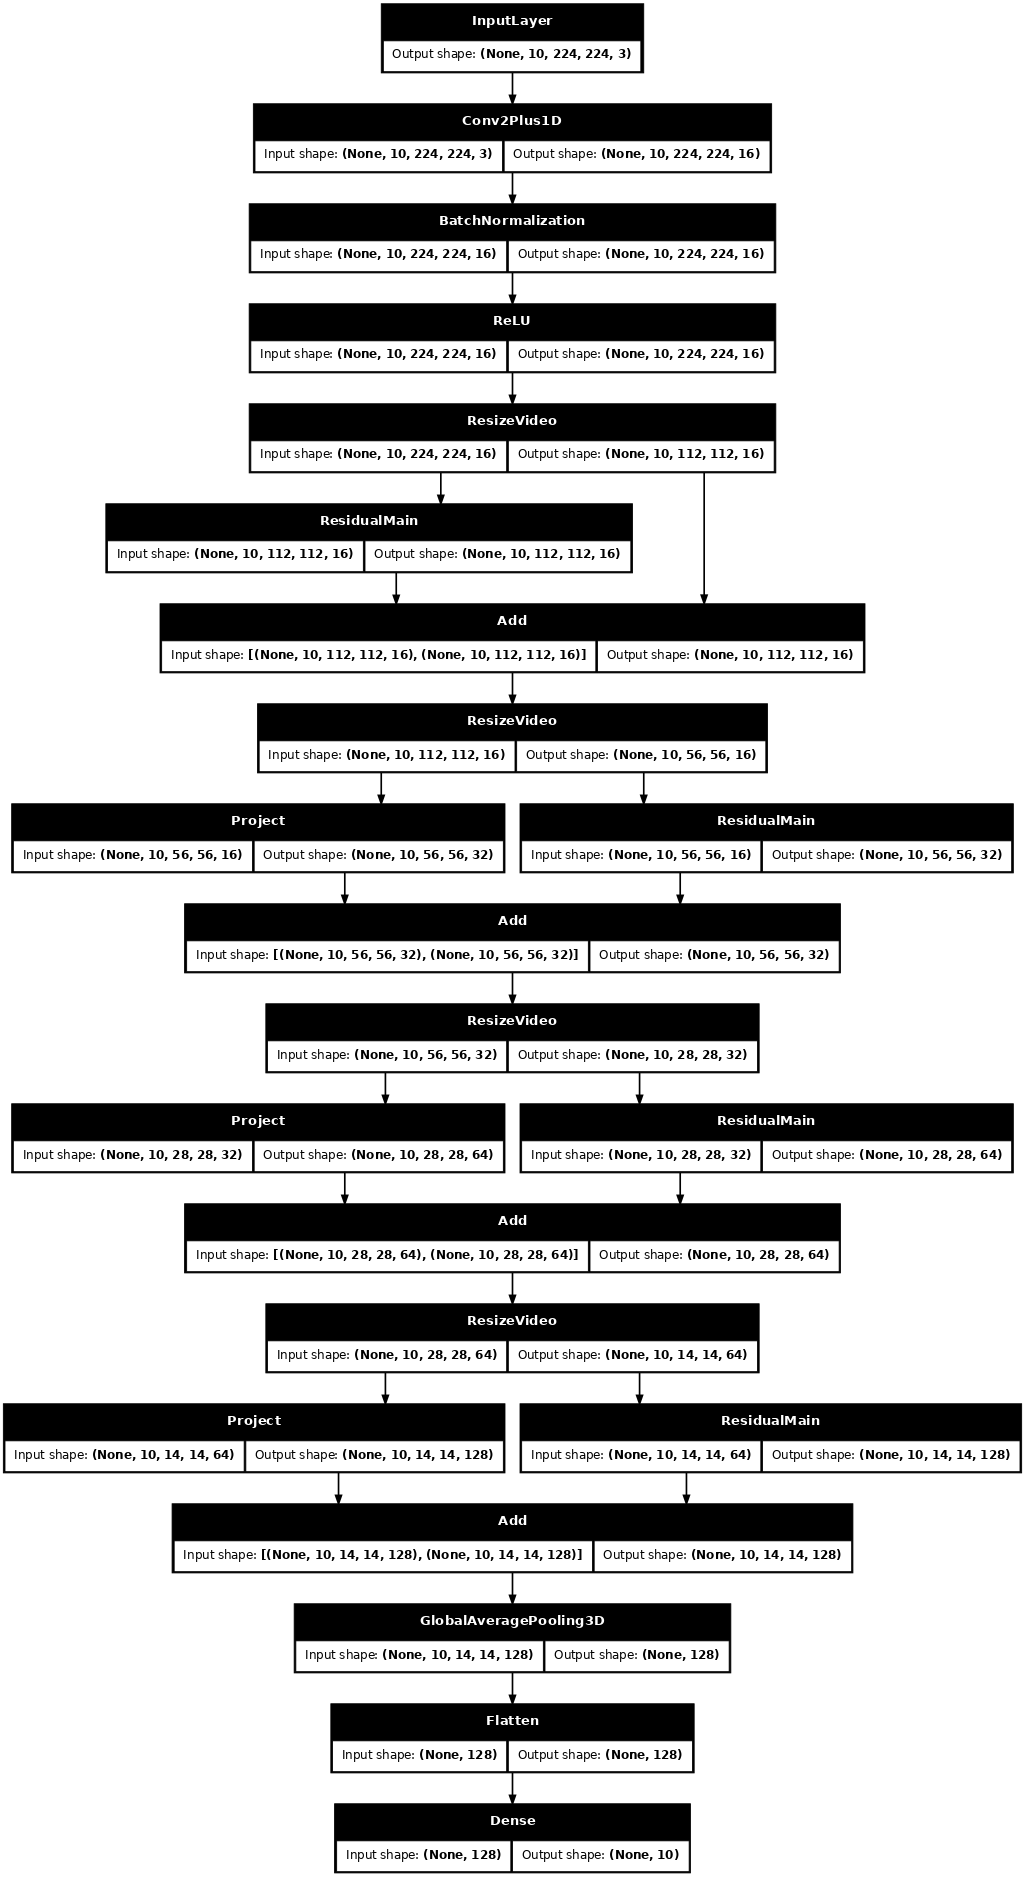

In [13]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [14]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [15]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


I0000 00:00:1764358703.859833   47381 service.cc:152] XLA service 0x7c9acc20ee50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764358703.859848   47381 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-28 20:38:24.003358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764358704.848308   47381 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-28 20:38:25.388858: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-28 20:38:25.518412: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution

      1/Unknown 15s 15s/step - accuracy: 0.0000e+00 - loss: 2.7732

2025-11-28 20:38:34.510977: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_4', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_3', 996 bytes spill stores, 1180 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_2', 408 bytes spill stores, 408 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_1', 504 bytes spill stores, 504 bytes spill loads

I0000 00:00:1764358714.552235   47381 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     59/Unknown 42s 452ms/step - accuracy: 0.1341 - loss: 2.5216

2025-11-28 20:39:01.980895: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-28 20:39:02.093372: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


     60/Unknown 49s 567ms/step - accuracy: 0.1344 - loss: 2.5194

2025-11-28 20:39:08.151932: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-11-28 20:39:08.152013: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/xy/Desktop/ml/TF/tf_2.19.1/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 59s 743ms/step - accuracy: 0.1480 - loss: 2.3886 - val_accuracy: 0.1467 - val_loss: 2.5309
Epoch 2/50


2025-11-28 20:39:18.523894: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 604ms/step - accuracy: 0.2220 - loss: 2.1497 - val_accuracy: 0.1902 - val_loss: 2.2485
Epoch 3/50


2025-11-28 20:39:54.703310: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - accuracy: 0.2854 - loss: 1.9484 - val_accuracy: 0.3641 - val_loss: 2.0339
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 604ms/step - accuracy: 0.2981 - loss: 1.9401 - val_accuracy: 0.2391 - val_loss: 2.1400
Epoch 5/50


2025-11-28 20:41:07.019384: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 603ms/step - accuracy: 0.3510 - loss: 1.7701 - val_accuracy: 0.2500 - val_loss: 2.2482
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 602ms/step - accuracy: 0.3975 - loss: 1.6853 - val_accuracy: 0.3098 - val_loss: 2.0170
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 606ms/step - accuracy: 0.4101 - loss: 1.6426 - val_accuracy: 0.2717 - val_loss: 1.8599
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 601ms/step - accuracy: 0.4440 - loss: 1.5144 - val_accuracy: 0.4457 - val_loss: 1.5684
Epoch 9/50


2025-11-28 20:43:31.499444: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 606ms/step - accuracy: 0.4799 - loss: 1.4548 - val_accuracy: 0.4891 - val_loss: 1.5163
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 606ms/step - accuracy: 0.5032 - loss: 1.3570 - val_accuracy: 0.5272 - val_loss: 1.3812
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 606ms/step - accuracy: 0.5307 - loss: 1.3158 - val_accuracy: 0.5489 - val_loss: 1.3048
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 607ms/step - accuracy: 0.5581 - loss: 1.3071 - val_accuracy: 0.6033 - val_loss: 1.1172
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - accuracy: 0.5560 - loss: 1.2497 - val_accuracy: 0.5870 - val_loss: 1.3026
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 606ms/step - accuracy: 0.5729 - loss: 1.1800 - val_accuracy: 0.5435 - val_loss: 1.3441
Epoch 15/50


2025-11-28 20:47:09.017445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5602740295851011058


60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 602ms/step - accuracy: 0.6385 - loss: 1.0677 - val_accuracy: 0.6141 - val_loss: 1.0408
Epoch 16/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 609ms/step - accuracy: 0.6385 - loss: 1.0315 - val_accuracy: 0.7011 - val_loss: 0.9689
Epoch 17/50


2025-11-28 20:48:21.563285: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 608ms/step - accuracy: 0.6533 - loss: 0.9798 - val_accuracy: 0.6630 - val_loss: 0.9828
Epoch 18/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 609ms/step - accuracy: 0.6364 - loss: 0.9734 - val_accuracy: 0.6630 - val_loss: 0.9672
Epoch 19/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 610ms/step - accuracy: 0.6596 - loss: 0.9837 - val_accuracy: 0.7228 - val_loss: 0.8714
Epoch 20/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 613ms/step - accuracy: 0.7273 - loss: 0.8663 - val_accuracy: 0.6576 - val_loss: 0.8897
Epoch 21/50


2025-11-28 20:50:47.497649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5602740295851011058


60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 608ms/step - accuracy: 0.7357 - loss: 0.8325 - val_accuracy: 0.7717 - val_loss: 0.7609
Epoch 22/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 607ms/step - accuracy: 0.7315 - loss: 0.7604 - val_accuracy: 0.7554 - val_loss: 0.7932
Epoch 23/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 609ms/step - accuracy: 0.7357 - loss: 0.7389 - val_accuracy: 0.7446 - val_loss: 0.7761
Epoch 24/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 601ms/step - accuracy: 0.7484 - loss: 0.7702 - val_accuracy: 0.6359 - val_loss: 1.0040
Epoch 25/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 604ms/step - accuracy: 0.7273 - loss: 0.7841 - val_accuracy: 0.7120 - val_loss: 0.7392
Epoch 26/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 607ms/step - accuracy: 0.7717 - loss: 0.6817 - val_accuracy: 0.7337 - val_loss: 0.8462
Epoch 27/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 607ms/step - accuracy: 0.7759 - loss: 0.6951 - val_accuracy: 0.6902 - val_loss: 0.8391
Epoch 28/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - accuracy: 0.7505 - loss: 0.6815 - val_accuracy

2025-11-28 20:58:03.032194: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 612ms/step - accuracy: 0.7632 - loss: 0.6454 - val_accuracy: 0.7065 - val_loss: 0.7587
Epoch 34/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 611ms/step - accuracy: 0.8097 - loss: 0.5367 - val_accuracy: 0.8261 - val_loss: 0.5883
Epoch 35/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 609ms/step - accuracy: 0.8266 - loss: 0.5429 - val_accuracy: 0.8043 - val_loss: 0.6484
Epoch 36/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 606ms/step - accuracy: 0.8266 - loss: 0.5768 - val_accuracy: 0.7772 - val_loss: 0.6949
Epoch 37/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 611ms/step - accuracy: 0.8118 - loss: 0.5356 - val_accuracy: 0.7609 - val_loss: 0.8433
Epoch 38/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 613ms/step - accuracy: 0.7865 - loss: 0.6227 - val_accuracy: 0.7174 - val_loss: 0.8104
Epoch 39/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 609ms/step - accuracy: 0.8140 - loss: 0.5615 - val_accuracy: 0.7609 - val_loss: 0.6116
Epoch 40/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 609ms/step - accuracy: 0.8140 - loss: 0.5053 - val_accuracy

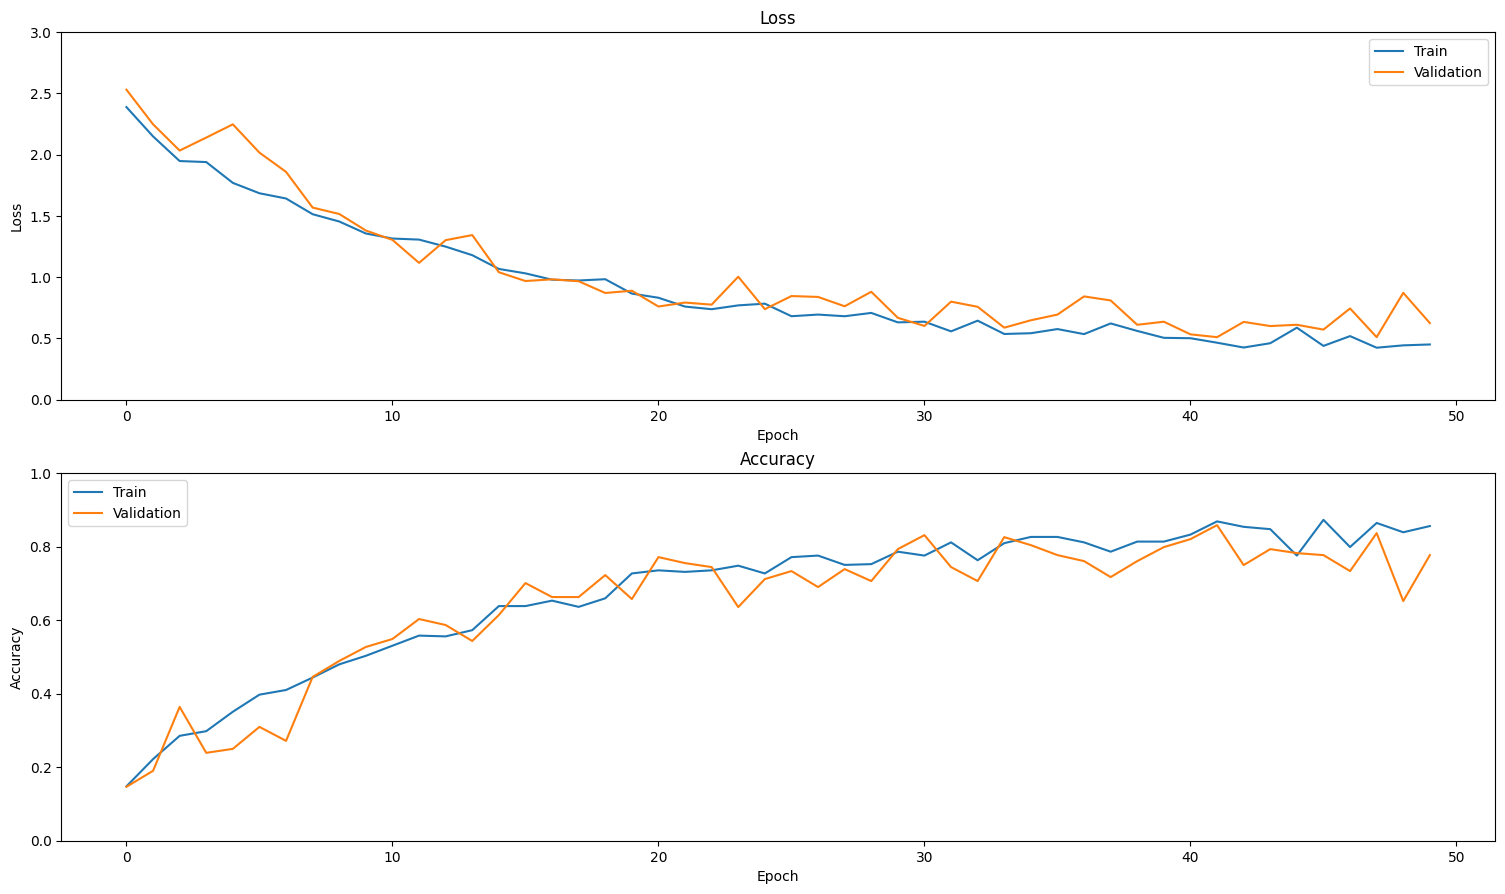

In [16]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [17]:
model.evaluate(test_ds, return_dict=True)

     23/Unknown 9s 402ms/step - accuracy: 0.8001 - loss: 0.7879

2025-11-28 21:09:12.217999: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-28 21:09:12.342261: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 0.7527 - loss: 0.7410


{'accuracy': 0.7526881694793701, 'loss': 0.7410264611244202}

In [18]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [19]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [20]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 401ms/step


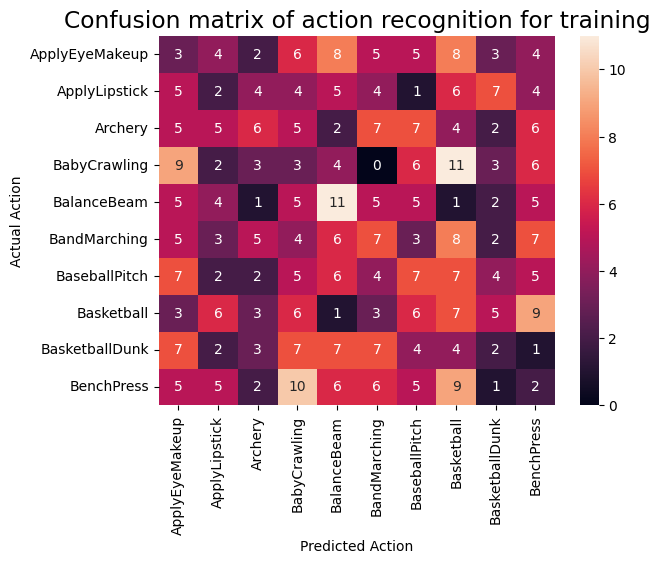

In [21]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 440ms/step


/home/xy/Desktop/ml/TF/tf_2.19.1/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


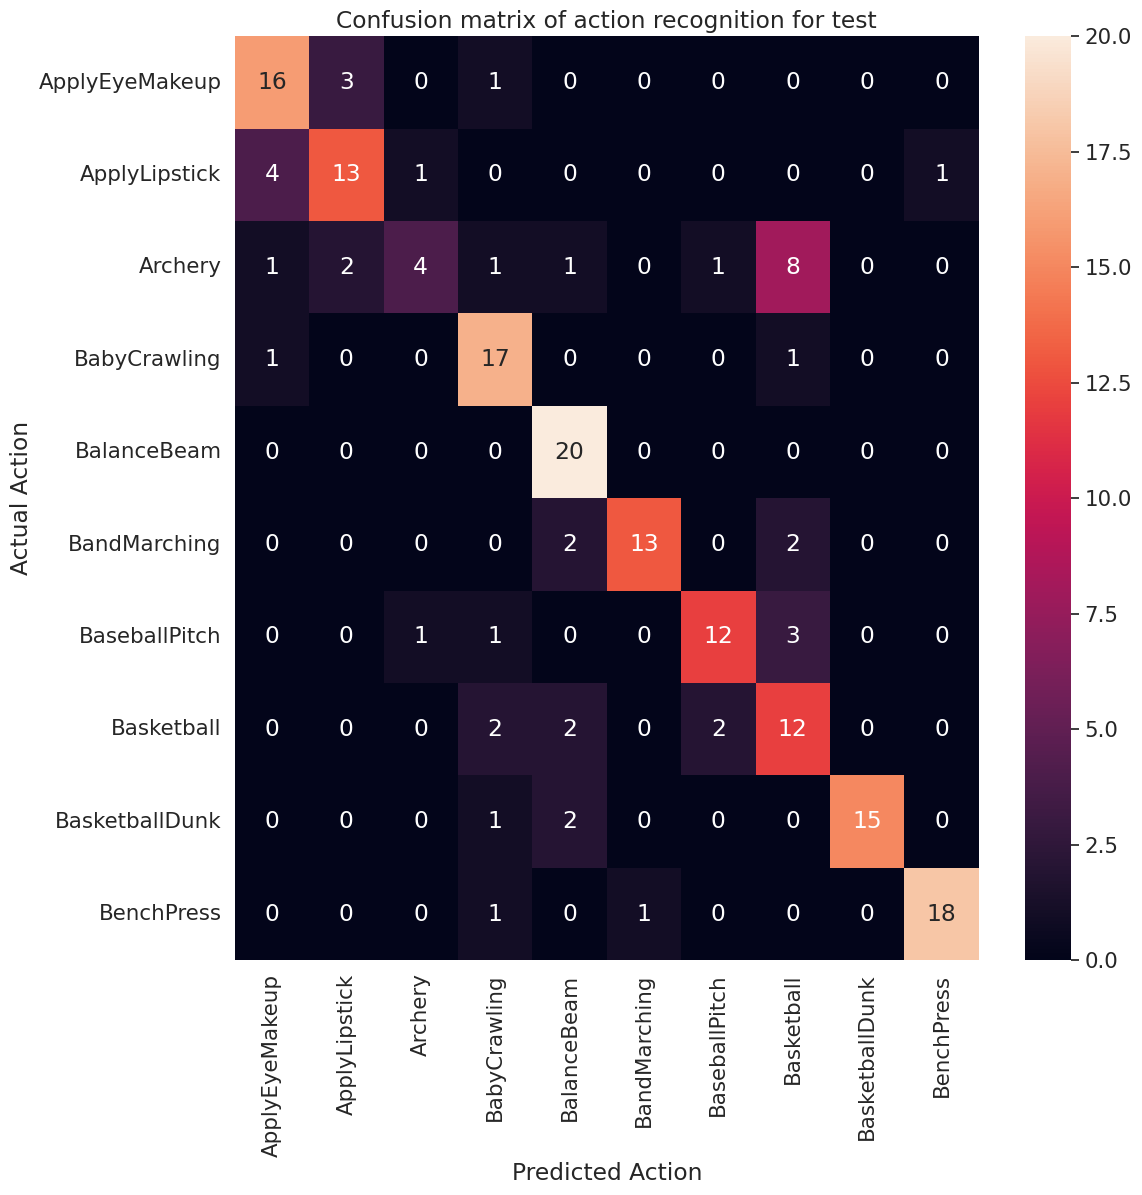

In [22]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [23]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [24]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [25]:
precision

{'ApplyEyeMakeup': 0.7272727272727273,
 'ApplyLipstick': 0.7222222222222222,
 'Archery': 0.6666666666666666,
 'BabyCrawling': 0.7083333333333334,
 'BalanceBeam': 0.7407407407407407,
 'BandMarching': 0.9285714285714286,
 'BaseballPitch': 0.8,
 'Basketball': 0.46153846153846156,
 'BasketballDunk': 1.0,
 'BenchPress': 0.9473684210526315}

In [26]:
recall

{'ApplyEyeMakeup': 0.8,
 'ApplyLipstick': 0.6842105263157895,
 'Archery': 0.2222222222222222,
 'BabyCrawling': 0.8947368421052632,
 'BalanceBeam': 1.0,
 'BandMarching': 0.7647058823529411,
 'BaseballPitch': 0.7058823529411765,
 'Basketball': 0.6666666666666666,
 'BasketballDunk': 0.8333333333333334,
 'BenchPress': 0.9}